src: [High-Quality Prediction Intervals for Deep Learning: A Distribution-Free, Ensembled Approach](https://proceedings.mlr.press/v80/pearce18a.html)


verdict : seems to be lot more involved than deep ensembles. In the loss function, requires careful tuning of the smoothing parameter, the lambda parameter(which controls how much importance to give to the prediction coverage). These parameters differed froom the two toy datasets in this notebook (one was used with deep ensembles, the other from this paper).

Additional reference to the official github for this paper: https://github.com/TeaPearce/Deep_Learning_Prediction_Intervals/blob/master/QD_AsFastAsPoss_notebook.ipynb


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import trange

In [2]:
# ensemble size
M = 5 


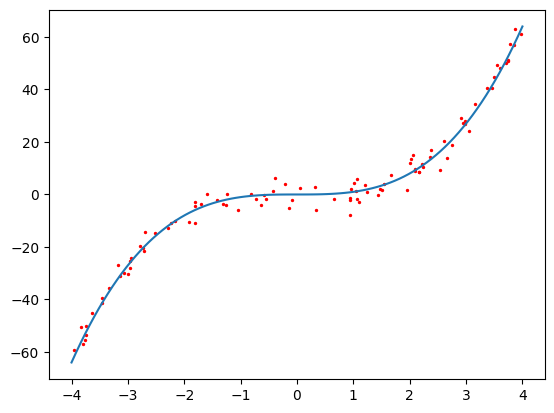

In [82]:
# create toy dataset
# np.random.seed(42)
N=100

X_train = torch.tensor(np.random.uniform(-4,4,N)).float()
eps = torch.tensor(np.random.normal(0,3,N)).float()
y_train = (X_train**3) + (eps)

X_test = torch.tensor(np.linspace(-4,4,100)).float()
y_test = (X_test**3)

plt.scatter(X_train, y_train,c='r',s=2)
plt.plot(X_test, y_test)
plt.show()



In [28]:
# create some data
# n_samples = 100
# X = np.random.uniform(low=-2.,high=2.,size=(n_samples,1))
# y = 1.5*np.sin(np.pi*X[:,0]) + np.random.normal(loc=0.,scale=1.*np.power(X[:,0],2))
# y = y.reshape([-1,1])/5.
# X_test = torch.linspace(-2,2,100) # for evaluation plots
# X_train,y_train=torch.tensor(X).float().flatten(),torch.tensor(y).float().flatten()

torch.Size([100, 2])


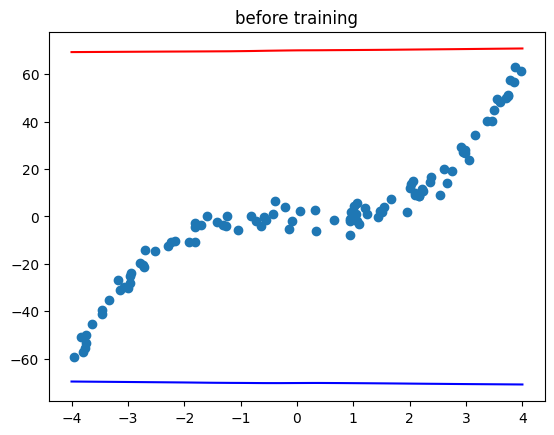

In [117]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1,100),
            nn.ReLU(),
            # nn.Linear(100,100),
            # nn.ReLU(),
            nn.Linear(100,2)
        )
        # self.net[-1].bias.data = torch.tensor([-3., 3.])
        # NOTE init biases to help model learn faster
        self.net[-1].bias.data = torch.tensor([-70., 70.])
    def forward(self,x):
        return self.net(x)

m = Model()

yhat = m(X_test.unsqueeze(-1))
print(yhat.shape)
lower,upper = yhat[:,0].detach(),yhat[:,1].detach()
plt.scatter(X_train.flatten(),y_train.flatten())
plt.plot(X_test,lower,c='b')
plt.plot(X_test,upper,c='r')
plt.title('before training')
plt.show()

14.924553871154785


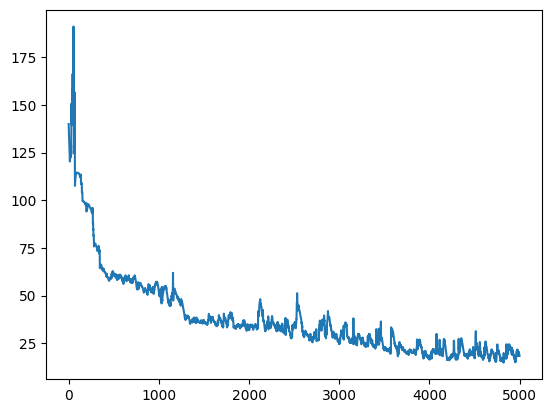

In [118]:
def loss_fn(yl,yh, y,n,alpha=0.05,s=60,lamb=0.5):
    khu = torch.maximum(torch.zeros_like(y),torch.sign(yh-y))
    khl = torch.maximum(torch.zeros_like(y),torch.sign(y-yl))
    kh = khu*khl

    ksu = F.sigmoid((yh-y)*s)
    ksl = F.sigmoid((y-yl)*s)
    ks = ksu*ksl

    mpiw = torch.sum(((yh-yl)*kh))/(torch.sum(kh)+1e-3)
    picp_s = torch.mean(ks)
    loss_s = mpiw + lamb*(n/(alpha*(1-alpha)))*torch.max(torch.zeros_like(picp_s),((1-alpha)-picp_s))**2

    return loss_s


def train_model(model, loss_fn, epochs=1000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    train_loss = []
    for i in range(epochs):
        # zero gradients
        optimizer.zero_grad()
        # forward pass 
        # rand_indices = torch.randperm(len(X_train))
        # X_train_randorder = X_train[rand_indices]
        # y_train_randorder = y_train[rand_indices]
        out = model(X_train.unsqueeze(-1))
        loss = loss_fn(out[:,0],out[:,1],y_train,n=len(X_train))
        # if i%100==0:
        #     yhat = model(X_test.unsqueeze(-1))
        #     lower, upper = yhat[:,0].detach(),yhat[:,1].detach()
        #     plt.scatter(X_train,y_train)
        #     plt.plot(X_test,lower,c='b')
        #     plt.plot(X_test,upper,c='r')
        #     plt.title(f"epoch {i}")
        #     plt.show()
        # print(loss)
        # backward pass
        loss.backward()
        
        optimizer.step()
        # metrics
        train_loss.append(loss.item())
        # break
    return model, train_loss

m, train_loss = train_model(
    Model(),
    loss_fn,
    epochs=5000,
    lr=1e-2
)
plt.plot(train_loss)
print(min(train_loss))

tensor(0.9400) tensor(17.7673, grad_fn=<MeanBackward0>)


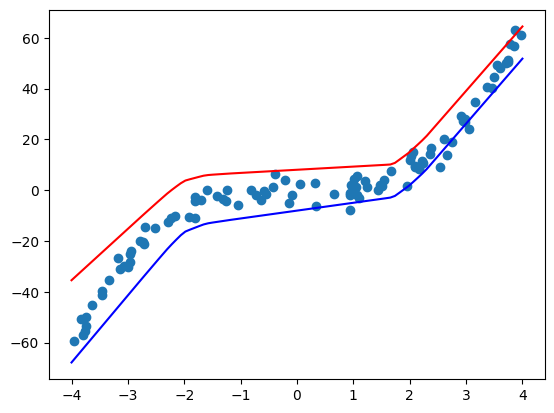

In [119]:
yhat = m(X_train.unsqueeze(-1))
lower, upper = yhat[:,0],yhat[:,1]

kl = lower<=y_train
ku = upper>=y_train
PICP = torch.mean(ku.float()*kl.float())
MPIW = torch.mean(upper-lower)
print(PICP, MPIW)
plt.scatter(X_train,y_train)

yhat = m(X_test.unsqueeze(-1))
lower, upper = yhat[:,0].detach(),yhat[:,1].detach()
plt.plot(X_test,lower,c='b')
plt.plot(X_test,upper,c='r')

In [120]:
models = [train_model(Model(),loss_fn,epochs=5000,lr=1e-2)[0] for _ in trange(M)]

  0%|          | 0/5 [00:00<?, ?it/s]

(100,)


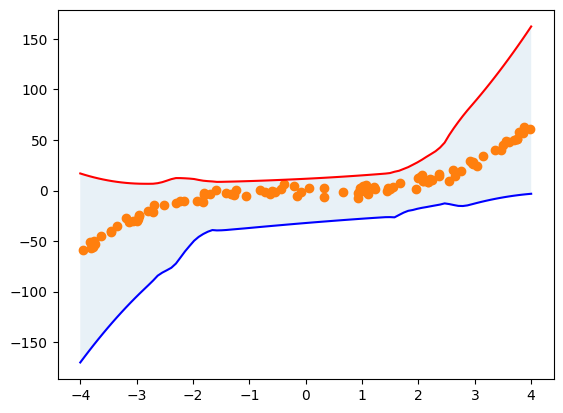

In [121]:
# plt.plot(X_test,y_test)
lowers, uppers = [],[]
for m in models:
    out = m(X_test.unsqueeze(1)).detach()
    # out = m(X_test).detach()
    yl,yh = out[:,0],out[:,1]
    lowers.append(yl)
    uppers.append(yh)

lowers = np.array(lowers)
uppers = np.array(uppers)

lower_mean = np.mean(lowers,axis=0)
lower_var = (1/(M-1))*np.sum((lowers-lower_mean)**2, axis=0)
lower_final = lower_mean-1.96*lower_var
print(lower_final.shape)

upper_mean = np.mean(uppers,axis=0)
upper_var = (1/(M-1))*np.sum((uppers-upper_mean)**2,axis=0)
upper_final = upper_mean+1.96*upper_var

plt.fill_between(
    X_test,
    upper_final,
    lower_final,
    alpha=0.1
)
plt.scatter(X_train,y_train)
plt.plot(X_test,lower_final,c='blue')
plt.plot(X_test,upper_final,c='red')
